# 📘 Assignment 2 - Predicting Length of Stay in ICU Patients with diseases of the digestive system

This notebook presents a complete machine learning pipeline to predict the length of stay (LOS) in the ICU for patients diagnosed with diseases of the digestive system using the MIMIC-III dataset (https://mimic.mit.edu/docs/iii/tables/). The goal is to estimate the expected duration of ICU stay early in the admission process, which can help optimize resource allocation and patient care.


  
**Authors Group O**  
- Fabian Alexander Bug (ID: 202412325)  
- Gabriele Pascali (ID: 202411175)  
- Giulio Tamburini (ID: 202411174)  

**Course**: Machine Learning 2024  
**Professors**: Ines Dutra, Maria Pedroto  
**Date**: June 3rd, 2025  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/ML_ass2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ML_ass2


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

## Data Preprocessing
In this phase, we load all the necessary MIMIC-III tables and filter the dataset to include only patients who were diagnosed with diseases of the digestive system (ICD9 code from `520` to `579`). We also ensure the correct linkage of patient records across the hospital admission and ICU stay tables. Additionally, we prepare the patient's age at admission for further use in modeling.

In [ ]:
d_icd = pd.read_csv("D_ICD_DIAGNOSES.csv")
# Clean and extract the first 3 digits as numeric for classification grouping
d_icd = d_icd[d_icd["ICD9_CODE"].str.isnumeric()]  # remove V/E codes for now
d_icd["ICD9_SHORT"] = d_icd["ICD9_CODE"].str[:3].astype(int)
d_icd.drop(columns=["ROW_ID", 'LONG_TITLE'], inplace=True)

In [ ]:
# Step1: Filter by the considered disease and select patient that has that disease
diagnoses_icd = pd.read_csv("DIAGNOSES_ICD.csv")
diagnoses_icd = pd.read_csv("DIAGNOSES_ICD.csv")

diagnoses_icd = diagnoses_icd.dropna(subset=["ICD9_CODE"])

diagnoses_icd = diagnoses_icd[diagnoses_icd["ICD9_CODE"].str.isnumeric()]  # remove V/E codes for now
diagnoses_icd["ICD9_SHORT"] = diagnoses_icd["ICD9_CODE"].str[:3].astype(int)
df = diagnoses_icd[
    (diagnoses_icd["ICD9_SHORT"] >= 520) & (diagnoses_icd["ICD9_SHORT"] <= 579)
]

df.drop(columns=['ROW_ID', "ICD9_CODE",'ICD9_SHORT', 'SEQ_NUM'], inplace=True)
del diagnoses_icd

df.shape, list(df.columns)

<ipython-input-645-803206aa0b69>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['ROW_ID', "ICD9_CODE",'ICD9_SHORT', 'SEQ_NUM'], inplace=True)


((38527, 2), ['SUBJECT_ID', 'HADM_ID'])

In [ ]:
# Step 2: Merge with ADMISSIONS
admissions = pd.read_csv("ADMISSIONS.csv", usecols=[ "HADM_ID", "ADMITTIME", "ADMISSION_TYPE", "HOSPITAL_EXPIRE_FLAG"])
df = df.merge(admissions, on=['HADM_ID'], how='inner')
del admissions

df.shape, list(df.columns)

((38527, 5),
 ['SUBJECT_ID',
  'HADM_ID',
  'ADMITTIME',
  'ADMISSION_TYPE',
  'HOSPITAL_EXPIRE_FLAG'])

In [ ]:
# Step 3: Merge with ICUSTAYS
icustays = pd.read_csv("ICUSTAYS.csv", usecols=["HADM_ID", "ICUSTAY_ID", "INTIME", 'FIRST_CAREUNIT', "LOS", 'DBSOURCE'])

icustays = icustays[icustays['DBSOURCE'] == 'metavision'] # we choose as db source 'Metavision?
icustays.drop(columns=["DBSOURCE"], inplace=True)
df = df.merge(icustays, on=['HADM_ID'], how='inner')
del icustays

df.shape, list(df.columns)

((23729, 9),
 ['SUBJECT_ID',
  'HADM_ID',
  'ADMITTIME',
  'ADMISSION_TYPE',
  'HOSPITAL_EXPIRE_FLAG',
  'ICUSTAY_ID',
  'FIRST_CAREUNIT',
  'INTIME',
  'LOS'])

In [ ]:
# Step 4: Merge with PATIENTS (on SUBJECT_ID)
patients = pd.read_csv("PATIENTS.csv", usecols=["SUBJECT_ID", "GENDER", "DOB"])
df = df.merge(patients, on='SUBJECT_ID', how='inner')
del patients

df.shape, list(df.columns)

((23729, 11),
 ['SUBJECT_ID',
  'HADM_ID',
  'ADMITTIME',
  'ADMISSION_TYPE',
  'HOSPITAL_EXPIRE_FLAG',
  'ICUSTAY_ID',
  'FIRST_CAREUNIT',
  'INTIME',
  'LOS',
  'GENDER',
  'DOB'])

#### Age Analysis
From the database documentation (https://mimic.mit.edu/docs/iii/tables/patients/):

"*DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission.*"

According to the U.S. HIPAA Privacy Rule, any data that could potentially be used to re-identify a patient must be anonymized. Patients older than 89 are considered uniquely identifiable, especially when combined with other information like diseases and location.

Because of this anonymization policy, patients who appear to be born before 1950 are likely to have been subjected to this artificial date shift.

To avoid these outliers, we have decided to remove all patients with a "shifted bithdate".


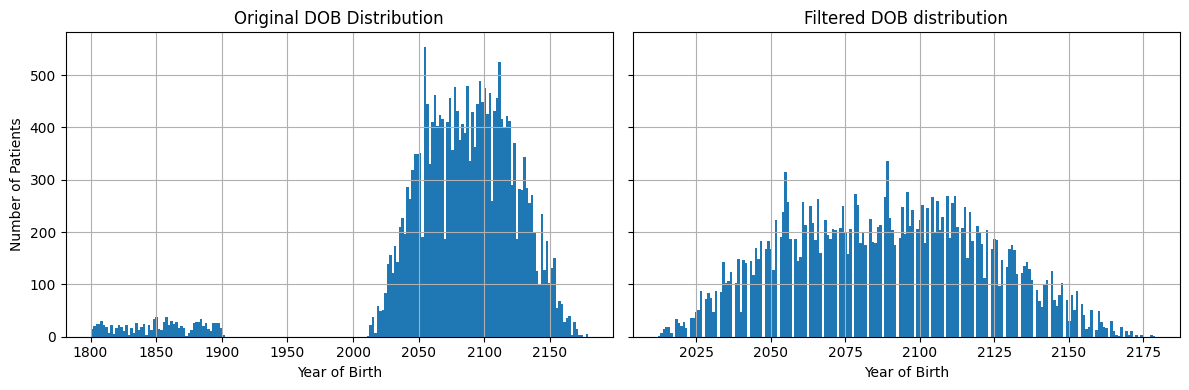

In [ ]:
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')

# Create subplot layout
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Original DOB distribution
df['DOB'].dt.year.hist(bins=200, ax=axes[0])
axes[0].set_title("Original DOB Distribution")
axes[0].set_xlabel("Year of Birth")
axes[0].set_ylabel("Number of Patients")
axes[0].grid(True)

# Filter and plot adjusted DOB
df = df[df['DOB'] >= '1950-01-01']
df['DOB'].dt.year.hist(bins=200, ax=axes[1])
axes[1].set_title("Filtered DOB distribution")
axes[1].set_xlabel("Year of Birth")
axes[1].grid(True)

plt.tight_layout()
plt.show()

To better understand the patient population and to ensure consistency in modeling, we compute each patient's age at the time of hospital admission. This is done by subtracting the date of birth (`DOB`) from the hospital admission time (`ADMITTIME`), and dividing the result by 365.25 to account for leap years.

We then apply a filter to keep only adult patients (age ≥ 18), since clinical management, ICU protocols, and outcomes can vary significantly between pediatric and adult populations. Excluding minors also improves the consistency and reliability of the predictive model.

Finally, we visualize the age distribution of the adult patients with a histogram. This helps us assess whether the dataset contains any anomalies or skewed distributions that might influence the model.


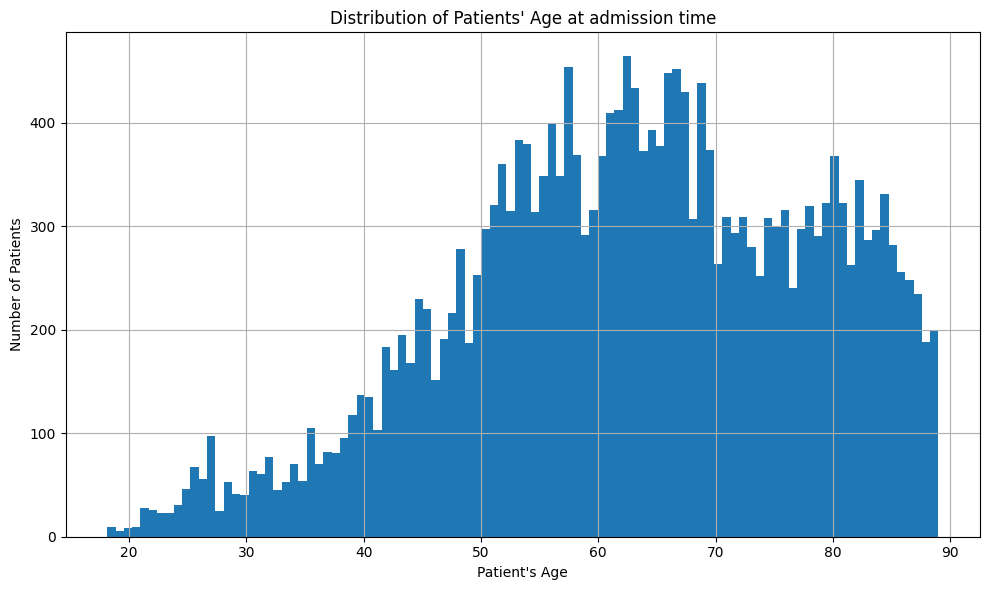

In [ ]:
# Compute age at admission
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['AGE'] = (df['ADMITTIME'] - df['DOB']).dt.days / 365.25 # Use 365.25 for leap years

df = df[df['AGE'] >= 18] # we consider adults only

# Plot histogram of the age of the patient at admission time in IUC
plt.figure(figsize=(10, 6))
df['AGE'].hist(bins=100)
plt.title("Distribution of Patients' Age at admission time")
plt.xlabel("Patient's Age")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Seperating Patients in different age groups

In [ ]:
# Define age bins and corresponding group labels
bins = [18, 29, 49, 69, 90]
labels = ['18-29', '30-49', '50-69', '70-89']

# Create a new column that categorizes each patient into an age group
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

# Count the number of patients in each age group
age_group_counts = df['AGE_GROUP'].value_counts(sort=False)
print("Number of Patients by Age Group:")
print(age_group_counts)

# Compute the average Length of Stay (LOS) for each age group
avg_los_per_age_group = df.groupby('AGE_GROUP')['LOS'].mean().reset_index()
print("\nAverage Length of Stay (LOS) by Age Group:")
print(avg_los_per_age_group)

Number of Patients by Age Group:
AGE_GROUP
18-29      522
30-49     3487
50-69    10459
70-89     8188
Name: count, dtype: int64

Average Length of Stay (LOS) by Age Group:
  AGE_GROUP       LOS
0     18-29  5.267798
1     30-49  4.450564
2     50-69  4.753254
3     70-89  4.280622


<ipython-input-652-1a0e93de6baf>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_los_per_age_group = df.groupby('AGE_GROUP')['LOS'].mean().reset_index()


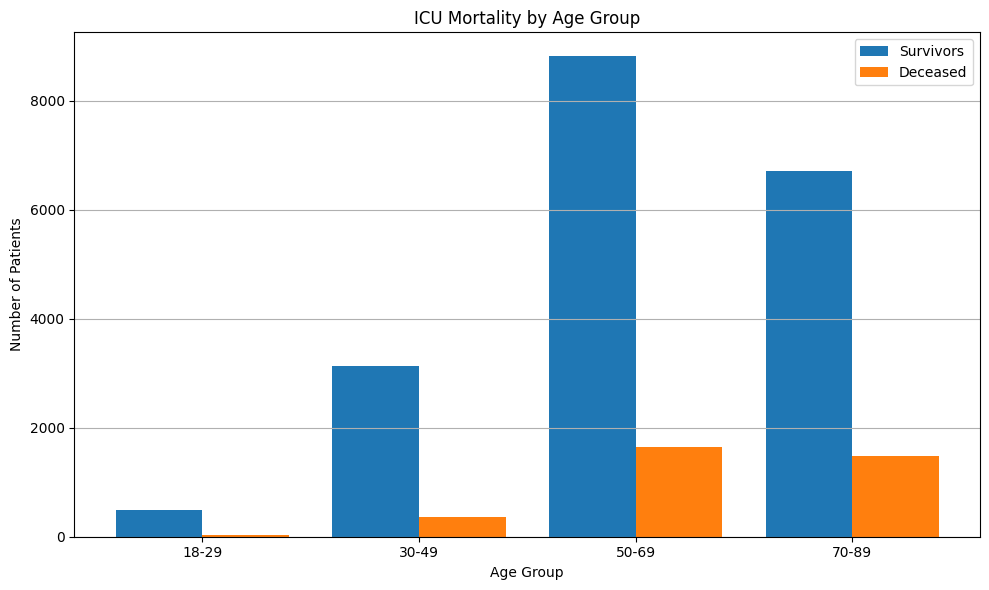

In [ ]:
# Separate by outcome
survivors = df[df["HOSPITAL_EXPIRE_FLAG"] == 0]
deceased = df[df["HOSPITAL_EXPIRE_FLAG"] == 1]

# Count by AGE_GROUP
survivor_counts = survivors["AGE_GROUP"].value_counts(sort=False)
deceased_counts = deceased["AGE_GROUP"].value_counts(sort=False)

# Ensure same index order
age_groups = ['18-29', '30-49', '50-69', '70-89']
survivor_counts = survivor_counts.reindex(age_groups, fill_value=0)
deceased_counts = deceased_counts.reindex(age_groups, fill_value=0)

# Plot
x = range(len(age_groups))
plt.figure(figsize=(10, 6))
plt.bar(x, survivor_counts.values, width=0.4, label='Survivors', align='center')
plt.bar([i + 0.4 for i in x], deceased_counts.values, width=0.4, label='Deceased', align='center')
plt.xticks([i + 0.2 for i in x], age_groups)
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.title('ICU Mortality by Age Group')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

del survivors, deceased

Now we drop patients that died during the hospitalization as they represent outliars for our model

In [ ]:
df = df[df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()  # we don't consider patients that died during the hospitalization
df.drop(columns=['HOSPITAL_EXPIRE_FLAG', 'DOB', 'ADMITTIME'], inplace=True)

df.shape, list(df.columns)

((19136, 10),
 ['SUBJECT_ID',
  'HADM_ID',
  'ADMISSION_TYPE',
  'ICUSTAY_ID',
  'FIRST_CAREUNIT',
  'INTIME',
  'LOS',
  'GENDER',
  'AGE',
  'AGE_GROUP'])

In order to incorporate patient history into the model, we define the feature NUM_PRIOR_ICU_STAYS, which represents the number of ICU admissions a patient had prior to the current ICU stay.

This is done by sorting the dataset by SUBJECT_ID and INTIME, and then applying a cumulative count using groupby().
The value is:

- 0 for the first ICU stay,

- 1 for the second, and so on.

Including this variable allows the model to take into account patient fragility and repeated ICU admissions, which are often correlated with longer stays and more complex conditions.



In [ ]:
# Sort the dataset by patient and ICU admission time
icustays_sorted = df.sort_values(by=['SUBJECT_ID', 'INTIME'])

# For each patient, count how many ICU stays occurred before the current one
df['NUM_PRIOR_ICU_STAYS'] = icustays_sorted.groupby('SUBJECT_ID').cumcount()

#### Medication
We start by loading the medication administration data from MetaVision (`mv.csv`). We then convert the `STARTTIME` of each input event to datetime format and merge this data with ICU stay metadata (`ICUSTAY_ID`, `HADM_ID`, `SUBJECT_ID`, and `INTIME`) from the main patient dataframe. This merge allows us to align each medication event with the patient's ICU admission time and filter the dataset to include only those events that occurred within the first 12 hours after ICU admission.  
Next, we load the `D_ITEMS.csv` file, which contains metadata about each `ITEMID`.

In [ ]:
TIME_WINDOW_SIZE = 12
# Load input events data
mv = pd.read_csv("INPUTEVENTS_MV.csv", usecols=['SUBJECT_ID', 'HADM_ID', "ICUSTAY_ID", "STARTTIME", "ITEMID", "AMOUNT", "AMOUNTUOM", "PATIENTWEIGHT"])


# Convert timestamps to datetime format
df['INTIME'] = pd.to_datetime(df['INTIME'])
mv['STARTTIME'] = pd.to_datetime(mv['STARTTIME'], errors='coerce')

# Merge ICU admission time (INTIME) and identifiers into the input events table
mv = mv.merge(df[['ICUSTAY_ID', 'HADM_ID', 'SUBJECT_ID', 'INTIME']],
             on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
             how='inner')

# Keep only medication administrations that occurred within the first 24 hours of ICU stay
mv = mv[
    (mv['STARTTIME'] >= mv['INTIME']) &
    (mv['STARTTIME'] <= mv['INTIME'] + pd.Timedelta(hours=TIME_WINDOW_SIZE))
]

In [ ]:
# Load item metadata
d_items = pd.read_csv("D_ITEMS.csv")

# Keep only rows related to MetaVision and with non-null labels
d_items = d_items[d_items['DBSOURCE'] == 'metavision']
d_items = d_items.dropna(subset=['LABEL'])

# Map ITEMID to its corresponding drug name (LABEL)
mv = mv.merge(d_items[['ITEMID', 'LABEL']], on='ITEMID', how='inner')

del d_items

To ensure consistency across the dataset, we standardize the `AMOUNT` values for medication administrations by unifying their units of measurement. Many `ITEMID`s appear with multiple units (e.g., milligrams, grams, micrograms, liters, milliliters), which would otherwise lead to inconsistent values during modeling.

We first define simple conversion rules to transform values into either `mg` or `ml` when possible. These rules are applied only for those `ITEMID`s that have multiple units, including `mg` or `ml`. For example, we convert grams to milligrams and liters to milliliters. This step ensures that the quantities of administered items are expressed in a consistent unit wherever possible.

Next, for all remaining `ITEMID`s that still appear with multiple units, we retain only the rows with the **most frequent unit of measurement** for each `ITEMID`. This eliminates rare or inconsistent unit cases, ensuring that each `ITEMID` is represented by a single dominant unit throughout the dataset.

This cleaning step improves the reliability and comparability of the `AMOUNT` feature, allowing it to be safely used in downstream modeling without introducing scale inconsistencies or semantic ambiguities.


In [ ]:
# Convert AMOUNT values to a consistent unit (mg or ml) for ITEMIDs with multiple units

# Define conversion rules
conversion_to_mg = {'grams': 1000, 'mcg': 1/1000}
conversion_to_ml = {'l': 1000}

# Identify ITEMIDs with multiple units including 'mg' or 'ml'
item_uom = mv.groupby('ITEMID')['AMOUNTUOM'].unique()
target_items = item_uom[item_uom.apply(lambda x: any(u in x for u in ['mg', 'ml']) and len(x) > 1)]

# Function to convert AMOUNT based on unit
def convert_amount(row):
    units = target_items.get(row['ITEMID'], [])
    uom = str(row['AMOUNTUOM']).lower()
    if uom in conversion_to_mg and 'mg' in units:
        return row['AMOUNT'] * conversion_to_mg[uom], 'mg'
    elif uom in conversion_to_ml and 'ml' in units:
        return row['AMOUNT'] * conversion_to_ml[uom], 'ml'
    return row['AMOUNT'], row['AMOUNTUOM']

# Apply conversion
mv[['AMOUNT', 'AMOUNTUOM']] = mv.apply(
    lambda row: pd.Series(convert_amount(row)), axis=1
)

In [ ]:
# Count the number of occurrences for each ITEMID + AMOUNTUOM combination
counts = mv.groupby(['ITEMID', 'AMOUNTUOM']).size().reset_index(name='count')

# For each ITEMID, find the most frequent unit of measurement (dominant unit)
dominant_uom = counts.sort_values('count', ascending=False).drop_duplicates('ITEMID')[['ITEMID', 'AMOUNTUOM']]

# Keep only rows with the dominant unit of measurement for each ITEMID
mv = mv.merge(dominant_uom, on=['ITEMID', 'AMOUNTUOM'], how='inner')

In [ ]:
# Keep PATIENTWEIGHT (first per ICUSTAY)
weight = mv[['ICUSTAY_ID', 'PATIENTWEIGHT']].dropna().drop_duplicates('ICUSTAY_ID', keep='first')

# count of different items administered
item_counts = mv.groupby('ICUSTAY_ID')['ITEMID'].nunique().reset_index(name='NUM_UNIQUE_ITEMS')

# -----------------------------
# Aggregate drug amounts per ITEMID
# -----------------------------
agg = mv.groupby(['ICUSTAY_ID', 'ITEMID'])['AMOUNT'].sum().reset_index()
pivot = agg.pivot_table(index='ICUSTAY_ID', columns='ITEMID', values='AMOUNT', fill_value=0).reset_index()
pivot.columns = ['ICUSTAY_ID'] + [f'ITEM_{int(col)}' for col in pivot.columns if col != 'ICUSTAY_ID']

# Combine all extracted features
features = pivot.merge(weight, on='ICUSTAY_ID', how='left')
features = features.merge(item_counts, on='ICUSTAY_ID', how='left')

# Merge into main dataframe
df = df.merge(features, on='ICUSTAY_ID', how='left')

# Fill missing drug values with 0
drug_cols = [col for col in pivot.columns if col != 'ICUSTAY_ID']
df[drug_cols] = df[drug_cols].fillna(0)

# Fill missing values in auxiliary features
df['PATIENTWEIGHT'] = df['PATIENTWEIGHT'].fillna(df['PATIENTWEIGHT'].median())
df['NUM_UNIQUE_ITEMS'] = df['NUM_UNIQUE_ITEMS'].fillna(0)

del mv

df.shape

(19136, 222)

We plot a Box Plot of the Lenght of Stay to detect any outliars.

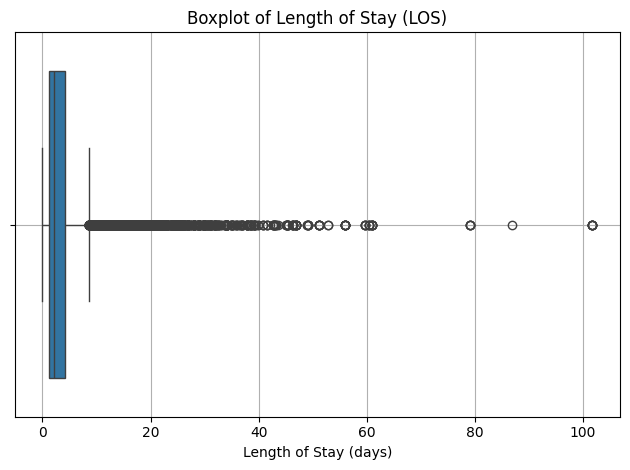

In [ ]:
sns.boxplot(x=df['LOS'])
plt.title("Boxplot of Length of Stay (LOS)")
plt.xlabel("Length of Stay (days)")
plt.grid(True)
plt.tight_layout()
plt.show()

We have to consider as outliars also the patients that stays in ICU less time than our time window of study

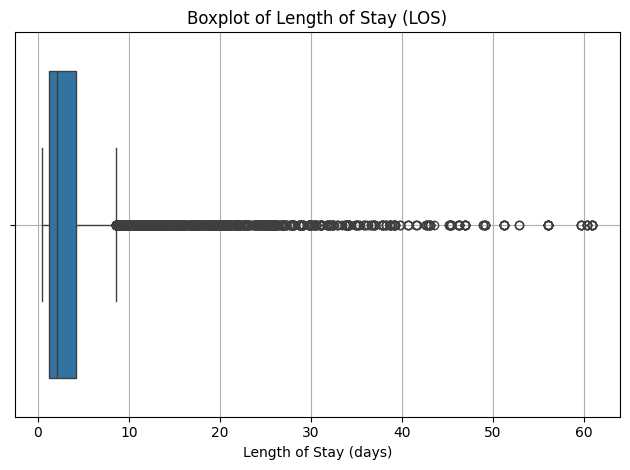

In [ ]:
# REMOVE THE OUTLIARS
df = df[df['LOS'] > 0.5]   # LOS = 0.5 means 12 hours
df = df[df['LOS'] < 70]

sns.boxplot(x=df['LOS'])
plt.title("Boxplot of Length of Stay (LOS)")
plt.xlabel("Length of Stay (days)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df.describe()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,INTIME,LOS,AGE,NUM_PRIOR_ICU_STAYS,ITEM_220862,ITEM_220864,ITEM_220949,...,ITEM_228315,ITEM_228316,ITEM_228339,ITEM_228340,ITEM_228351,ITEM_228359,ITEM_228363,ITEM_228383,PATIENTWEIGHT,NUM_UNIQUE_ITEMS
count,18908.000000,18908.000000,18908.000000,18908,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,...,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000
mean,61878.578221,149605.851333,249968.390152,2152-03-10 09:02:03.663687680,4.136888,62.411184,2.744288,35.396895,100.579638,963.586120,...,73.024646,6.372964,1.929182,1.701864,5.968648,1.433220,0.736760,0.004575,81.711318,8.763751
min,36.000000,100001.000000,200010.000000,2100-06-07 20:00:22,0.502800,18.132786,0.000000,0.000000,0.000000,-17500.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,46337.000000,124711.000000,225339.000000,2125-12-09 04:07:03.499999232,1.280975,52.222450,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.600000,5.000000
50%,63847.000000,149358.000000,249776.000000,2152-08-01 01:08:27.000000512,2.140550,63.055441,1.000000,0.000000,0.000000,387.936982,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.800000,8.000000
75%,81864.250000,173974.000000,274960.000000,2178-03-06 14:21:24,4.200600,74.532512,3.000000,0.000000,0.000000,1118.000012,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.800000,12.000000
max,99992.000000,199992.000000,299998.000000,2209-07-31 13:52:39,60.939000,88.999316,79.000000,9799.999829,13349.699536,40150.163052,...,14000.000000,6000.000400,2400.000095,1999.000072,8000.000312,5999.999938,4368.000000,86.500002,1410.000000,32.000000
std,24659.942965,28598.322798,28847.673170,NaN,5.746105,15.255350,5.363709,366.265009,619.392002,2173.741188,...,618.434040,159.559395,56.265459,45.573758,199.178222,84.489198,55.071511,0.629062,28.065066,4.862295


In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ICUSTAY_ID,FIRST_CAREUNIT,INTIME,LOS,GENDER,AGE,AGE_GROUP,...,ITEM_228315,ITEM_228316,ITEM_228339,ITEM_228340,ITEM_228351,ITEM_228359,ITEM_228363,ITEM_228383,PATIENTWEIGHT,NUM_UNIQUE_ITEMS
0,109,173633,EMERGENCY,284204,MICU,2141-12-08 01:41:35,1.8098,F,24.336756,18-29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.9,6.0
1,36,165660,ELECTIVE,241249,MICU,2134-05-12 06:52:47,4.3483,M,72.725530,70-89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.2,11.0
2,109,126055,EMERGENCY,236124,MICU,2141-10-13 23:11:01,11.9014,F,24.183436,18-29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.7,4.0
3,109,131376,EMERGENCY,299251,MICU,2142-07-07 10:02:10,1.3356,F,24.914442,18-29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,3.0
4,109,136572,EMERGENCY,286860,MICU,2142-06-18 03:13:11,0.8675,F,24.862423,18-29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.6,7.0


## Data Preparation
Here we engineer the features that will be used for prediction. The target variable is the length of stay in the ICU (`LOS`). We perform one-hot encoding on categorical features and normalize numerical ones. Finally, we split the dataset into training and test sets to evaluate generalization performance.

In [ ]:
# 'Target variable
y = df['LOS'].copy()

X = df.copy()
X.drop(columns=['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'INTIME', 'LOS', 'AGE'], inplace=True)
X.columns

Index(['ADMISSION_TYPE', 'FIRST_CAREUNIT', 'GENDER', 'AGE_GROUP',
       'NUM_PRIOR_ICU_STAYS', 'ITEM_220862', 'ITEM_220864', 'ITEM_220949',
       'ITEM_220950', 'ITEM_220952',
       ...
       'ITEM_228315', 'ITEM_228316', 'ITEM_228339', 'ITEM_228340',
       'ITEM_228351', 'ITEM_228359', 'ITEM_228363', 'ITEM_228383',
       'PATIENTWEIGHT', 'NUM_UNIQUE_ITEMS'],
      dtype='object', length=216)

In [ ]:
# Encode categorical features
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
cat_cols = ['GENDER', 'ADMISSION_TYPE', 'FIRST_CAREUNIT', 'AGE_GROUP']
X_cat = encoder.fit_transform(X[cat_cols])
encoded_cols = encoder.get_feature_names_out(cat_cols)


# Normalize numeric features
scaler = MinMaxScaler()
num_cols =  X.columns.difference(cat_cols)
X[num_cols] = scaler.fit_transform(X[num_cols])


# Final DataFrame
X_encoded = pd.DataFrame(X_cat, columns=encoded_cols, index=X.index)
X = pd.concat([X_encoded, X[num_cols]], axis=1)

# shuffle the data
X, y = shuffle(X, y, random_state=42)
X.head()

,GENDER_M,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU,AGE_GROUP_18-29,...,ITEM_228316,ITEM_228339,ITEM_228340,ITEM_228351,ITEM_228359,ITEM_228363,ITEM_228383,NUM_PRIOR_ICU_STAYS,NUM_UNIQUE_ITEMS,PATIENTWEIGHT
9995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215190,0.31250,0.049184
10006,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.34375,0.058907
17487,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075949,0.00000,0.055216
2923,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.31250,0.054081
6947,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050633,0.34375,0.047906


In [ ]:
# Train-test split
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Normalize y on training set
target_scaler = StandardScaler()
y_train_val_scaled = target_scaler.fit_transform(y_train_val.values.reshape(-1, 1)).ravel()

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train_scaled, y_val_scaled = train_test_split(X_train_val, y_train_val_scaled, test_size=0.15, random_state=42)

y_train = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()  # we will use it with

print(f'Shape of training datasets: {X_train.shape, y_train_scaled.shape}')
print(f'Shape of validation datasets: {X_val.shape, y_val_scaled.shape}')
print(f'Shape of test datasets: {X_test.shape, y_test.shape}')

Shape of training datasets: ((13660, 225), (13660,))
Shape of validation datasets: ((2411, 225), (2411,))
Shape of test datasets: ((2837, 225), (2837,))


## Neural Network using SCIKITLEARN
We train a neural network regressor (MLPRegressor), which models non-linear relationships between input features and the target. The network consists of multiple fully connected layers and is trained using backpropagation.
We evaluate model performance using:

- **RMSE**: Root Mean Squared Error, penalizes large deviations
- **MAE**: Mean Absolute Error, measures average absolute error
- **R²**: Coefficient of Determination, reflects how well the model explains target variance


Training:
  MSE: 5.45
  MAE: 1.24
  R² : 0.84

Test:
  MSE: 9.56
  MAE: 1.60
  R² : 0.71


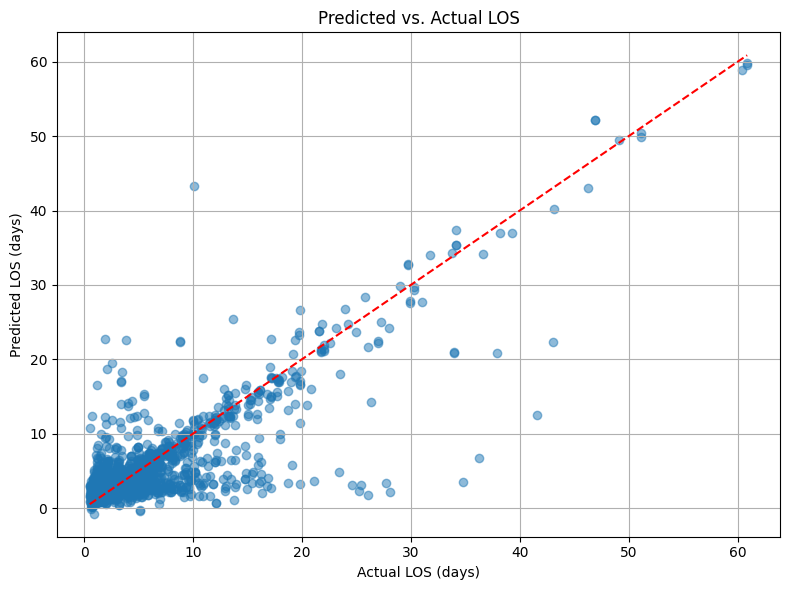

In [ ]:
# Train the model
NN_scikit = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42, early_stopping=True)
NN_scikit.fit(X_train_val, y_train_val_scaled)

# Predict and inverse transform
y_test_pred_scaled = NN_scikit.predict(X_test)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

y_train_pred_scaled = NN_scikit.predict(X_train_val)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
print("Training:")
print(f"  MSE: {mean_squared_error(y_train_val, y_train_pred):.2f}")
print(f"  MAE: {mean_absolute_error(y_train_val, y_train_pred):.2f}")
print(f"  R² : {r2_score(y_train_val, y_train_pred):.2f}\n")

print("Test:")
print(f"  MSE: {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"  MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"  R² : {r2_score(y_test, y_test_pred):.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual LOS (days)")
plt.ylabel("Predicted LOS (days)")
plt.title("Predicted vs. Actual LOS")
plt.grid(True)
plt.tight_layout()
plt.show()

CROSS VALIDATION

In [ ]:
from sklearn.model_selection import cross_val_score
scores = -cross_val_score(NN_scikit, X_train_val, y_train_val, cv=5, scoring='neg_mean_absolute_error')
scores

array([2.0578006 , 1.82469743, 1.83301627, 1.69863445, 1.85804238])

### Analysis of Results and Interpretation
To better understand the model's decision-making process, we apply **SHAP (SHapley Additive exPlanations)** values, a game-theoretic approach to explain the output of machine learning models. SHAP provides a ranking of the features by their importance and shows how each feature contributes to increasing or decreasing the predicted length of stay.

This interpretability step is crucial for verifying the clinical relevance of the model and ensuring transparency in its use.

PermutationExplainer explainer: 2838it [10:31,  4.39it/s]


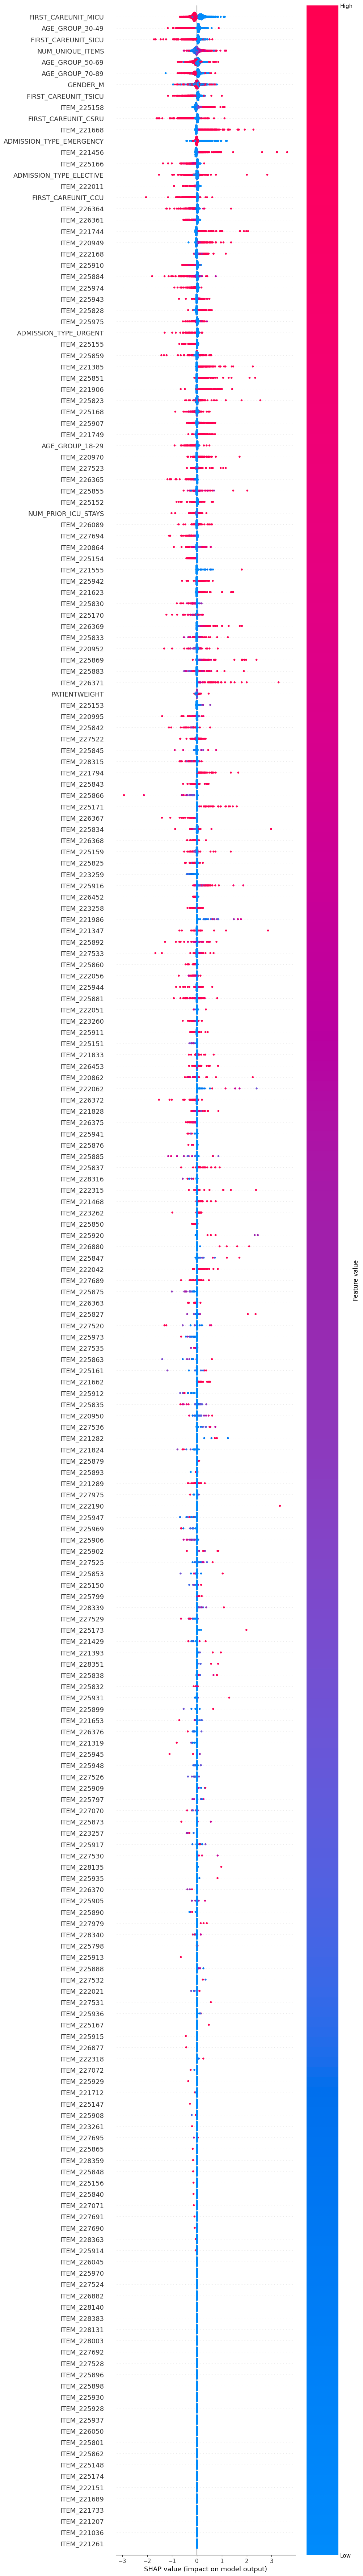

In [ ]:
import shap

# Explainer for scikit-learn models
explainer = shap.Explainer(NN_scikit.predict, X_train_val)
shap_values = explainer(X_test)

# Summary plot
shap.plots.beeswarm(shap_values, max_display=len(X.columns))

In [ ]:
threshold = 0.0002

# Calcola l'importanza media assoluta per ciascuna feature
mean_importance = np.abs(shap_values.values).mean(axis=0)

# Crea una Series ordinata
feature_importance = pd.Series(mean_importance, index=X_test.columns).sort_values(ascending=False)
features_to_drop = feature_importance[feature_importance < threshold].index


X.drop(columns=features_to_drop, inplace=True)
X.shape

(18908, 176)

### Second Training
Now we try to train the model again, removing the features that doesn't impact the predictions


In [ ]:
# Train-test split
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Normalize y on training set
target_scaler = StandardScaler()
y_train_val_scaled = target_scaler.fit_transform(y_train_val.values.reshape(-1, 1)).ravel()

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train_scaled, y_val_scaled = train_test_split(X_train_val, y_train_val_scaled, test_size=0.15, random_state=42)

y_train = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()  # we will use it with

print(f'Shape of training datasets: {X_train.shape, y_train_scaled.shape}')
print(f'Shape of validation datasets: {X_val.shape, y_val_scaled.shape}')
print(f'Shape of test datasets: {X_test.shape, y_test.shape}')

Shape of training datasets: ((13660, 176), (13660,))
Shape of validation datasets: ((2411, 176), (2411,))
Shape of test datasets: ((2837, 176), (2837,))


#### Train  the model

In [ ]:
# Train the model
NN_scikit = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42, early_stopping=True)
NN_scikit.fit(X_train_val, y_train_val_scaled)

# Predict and inverse transform
y_test_pred_scaled = NN_scikit.predict(X_test)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

y_train_pred_scaled = NN_scikit.predict(X_train_val)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
print("Training:")
print(f"  MSE: {mean_squared_error(y_train_val, y_train_pred):.2f}")
print(f"  MAE: {mean_absolute_error(y_train_val, y_train_pred):.2f}")
print(f"  R² : {r2_score(y_train_val, y_train_pred):.2f}\n")

print("Test:")
print(f"  MSE: {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"  MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"  R² : {r2_score(y_test, y_test_pred):.2f}")

Training:
  MSE: 5.59
  MAE: 1.27
  R² : 0.83

Test:
  MSE: 9.26
  MAE: 1.59
  R² : 0.71


## Neural Network using TENSORFLOW KERAS
To have an higher level of control on the model, we use the library of Tensorflow Keras to have a better analysis on the training. This will be our final model.


### Build  the model

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ dense_57 (Dense)            │ (None, 128)           │     22,656 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_19 (Dropout)        │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_58 (Dense)            │ (None, 64)            │      8,256 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_59 (Dense)            │ (None, 1)             │         65 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 30,977 (121.00 KB)

 Trainable params: 30,977 (121.00 KB)

 Non-trainable params: 0 (0.00 B)

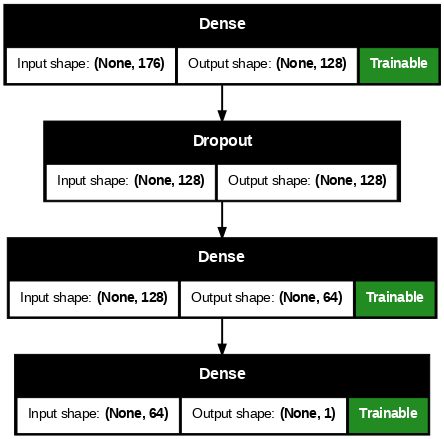

In [ ]:
# Build the model
NN_tfk = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, ac)  # Output layer for regression
])


NN_tfk.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mse']
)


NN_tfk.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(NN_tfk, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

### Train  the model

In [ ]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = NN_tfk.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=1000,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
).history

Epoch 1/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9466 - mse: 0.9466 - val_loss: 0.8361 - val_mse: 0.8361
Epoch 2/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7711 - mse: 0.7711 - val_loss: 0.7637 - val_mse: 0.7637
Epoch 3/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7091 - mse: 0.7091 - val_loss: 0.7102 - val_mse: 0.7102
Epoch 4/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.6477 - mse: 0.6477 - val_loss: 0.6843 - val_mse: 0.6843
Epoch 5/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.5817 - mse: 0.5817 - val_loss: 0.6379 - val_mse: 0.6379
Epoch 6/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5421 - mse: 0.5421 - val_loss: 0.6137 - val_mse: 0.6137
Epoch 7/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4810 - mse: 0.4810 - val_loss: 0.5900 - val_mse: 0.5900
Epoch 8/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4611 - mse: 0.4611 - val_loss: 0.5700 - val_mse: 0.5700
Epoch 9/1000
214/214 ━━━━━━━━━━━━━━━

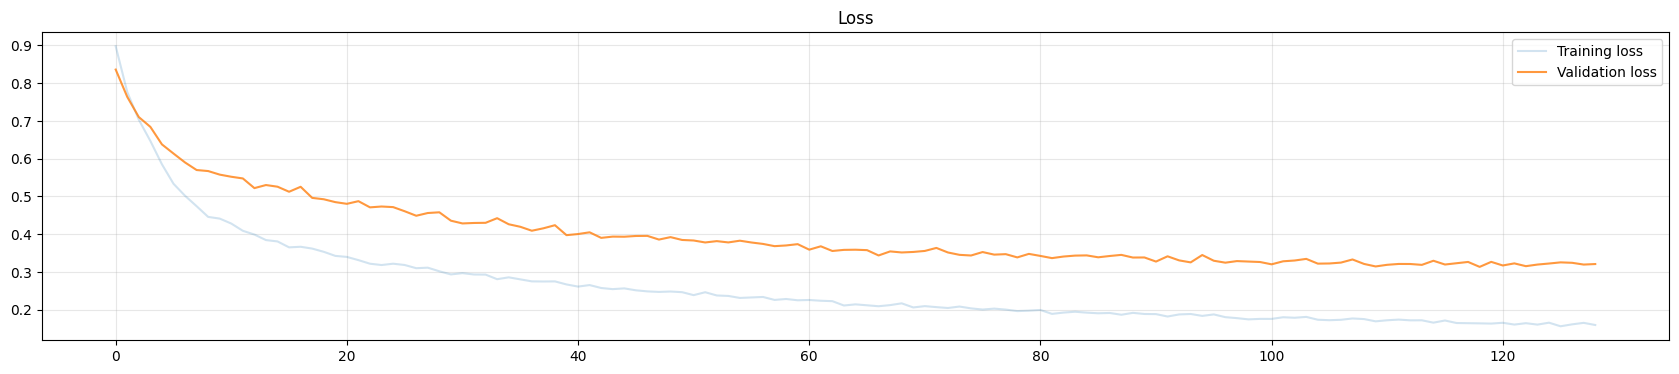

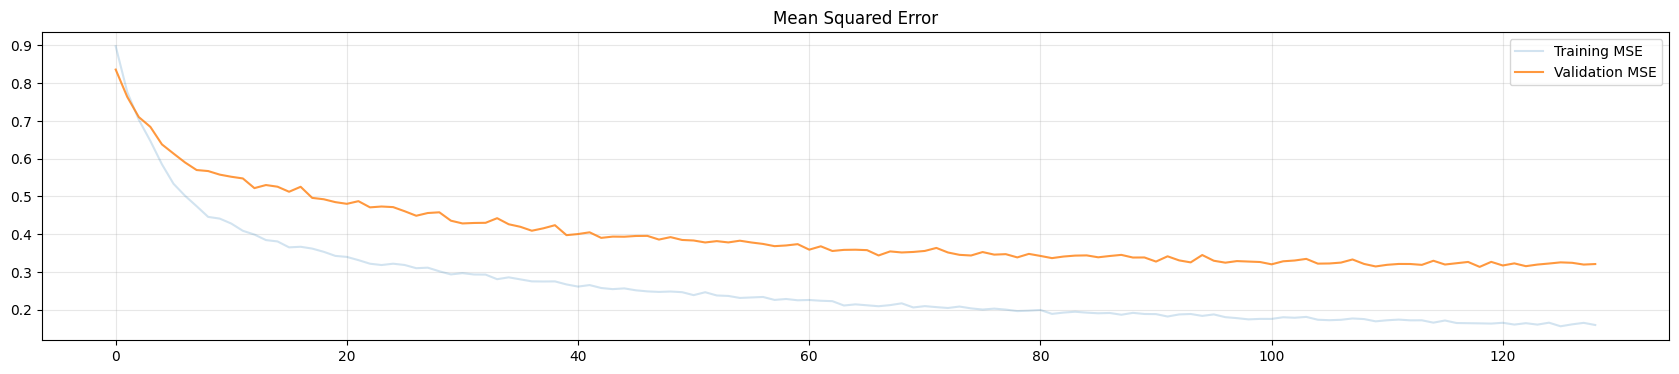

In [ ]:
# Create a figure for loss visualization
plt.figure(figsize=(21, 4))

# Plot training and validation loss
plt.plot(history['loss'], label='Training loss', alpha=.2)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Create a figure for Mean Squared Error visualization
plt.figure(figsize=(21, 4))

# Plot training and validation MSE
plt.plot(history['mse'], label='Training MSE', alpha=.2)
plt.plot(history['val_mse'], label='Validation MSE', alpha=.8)
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)

# Display the plots
plt.show()


### Test the model

427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training:
  MSE: 4.34
  MAE: 1.16
  R² : 0.87

Test:
  MSE: 8.22
  MAE: 1.51
  R² : 0.75


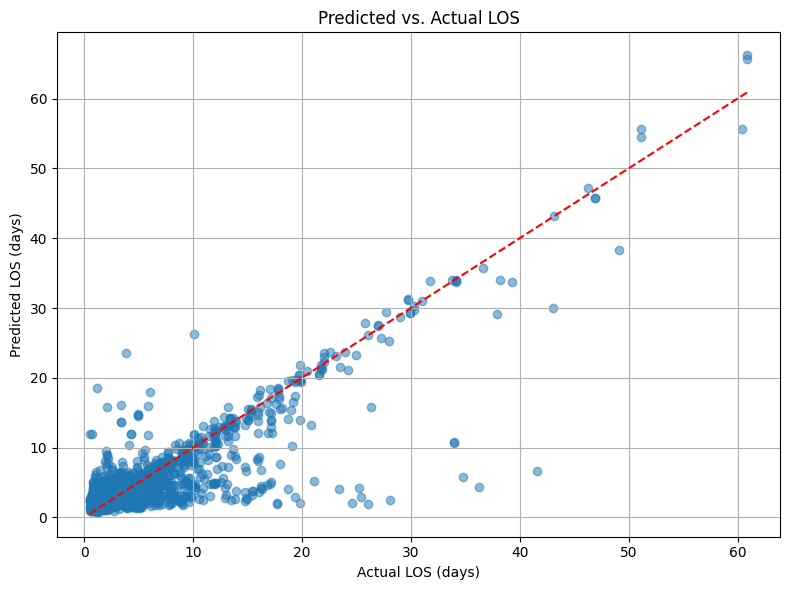

In [ ]:
# Predict and inverse-transform
y_train_pred_scaled = NN_tfk.predict(X_train).ravel()
y_test_pred_scaled = NN_tfk.predict(X_test).ravel()

y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
print("Training:")
print(f"  MSE: {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"  MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"  R² : {r2_score(y_train, y_train_pred):.2f}\n")

print("Test:")
print(f"  MSE: {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"  MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"  R² : {r2_score(y_test, y_test_pred):.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual LOS (days)")
plt.ylabel("Predicted LOS (days)")
plt.title("Predicted vs. Actual LOS")
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Training and Validation -- TABNET


Here, we try TabNet as oour model, which is a Neural Network model specifically designed for tabular data.

TabNet automatically selects the most important features and learns. After training, the model can be evaluated on the test set and used to interpret the most important influencing factors.

In [ ]:
!pip install pytorch-tabnet --quiet
from pytorch_tabnet.tab_model import TabNetRegressor

y_train_scaled = y_train_scaled.reshape(-1, 1)
y_val_scaled = y_val_scaled.reshape(-1, 1)

# Initialize the model
tabnet = TabNetRegressor(verbose=1, seed=42)

# Fit the model
tabnet.fit(
    X_train.values, y_train_scaled,
    eval_set=[(X_val.values, y_val_scaled)],
    max_epochs=200,
    patience=10,
    batch_size=64,
    virtual_batch_size=64,
    eval_metric=['rmse']
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00283 | val_0_rmse: 0.99954 |  0:00:08s
epoch 1  | loss: 0.90726 | val_0_rmse: 0.98437 |  0:00:18s
epoch 2  | loss: 0.85344 | val_0_rmse: 0.93702 |  0:00:28s
epoch 3  | loss: 0.8344  | val_0_rmse: 0.94068 |  0:00:36s
epoch 4  | loss: 0.816   | val_0_rmse: 0.9401  |  0:00:46s
epoch 5  | loss: 0.79481 | val_0_rmse: 0.89557 |  0:00:55s
epoch 6  | loss: 0.77083 | val_0_rmse: 0.90062 |  0:01:04s
epoch 7  | loss: 0.7497  | val_0_rmse: 0.9068  |  0:01:19s
epoch 8  | loss: 0.7579  | val_0_rmse: 0.92275 |  0:01:28s
epoch 9  | loss: 0.74005 | val_0_rmse: 0.88106 |  0:01:36s
epoch 10 | loss: 0.75794 | val_0_rmse: 0.87374 |  0:01:46s
epoch 11 | loss: 0.72296 | val_0_rmse: 0.90711 |  0:01:54s
epoch 12 | loss: 0.71305 | val_0_rmse: 0.87408 |  0:02:04s
epoch 13 | loss: 0.70121 | val_0_rmse: 0.93421 |  0:02:12s
epoch 14 | loss: 0.69696 | val_0_rmse: 0.87255 |  0:02:23s
epoch 15 | loss: 0.69376 | val_0_rmse: 1.05736 |  0:02:33s
epoch 16 | loss: 0.71435 | val_0_rmse: 0.932   |  0:02:4

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test:
  MSE: 18.42
  MAE: 2.43
  R² : 0.43


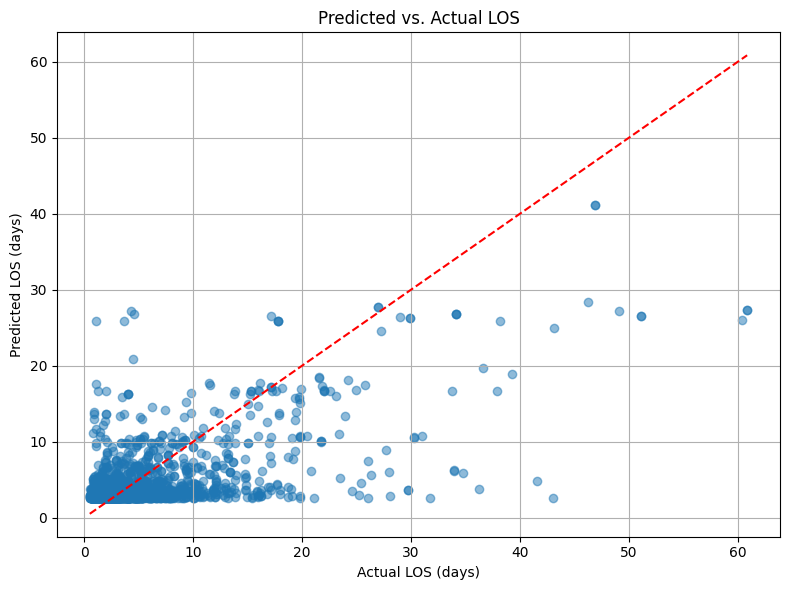

In [ ]:
y_test_pred_scaled = tabnet.predict(X_test.values)

if y_test_pred_scaled.ndim > 1 and y_test_pred_scaled.shape[1] > 1:
    y_test_pred_scaled = y_test_pred_scaled[:, 0]

# Backtransformation of Predictions
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_test_true = y_test.values  # Original LOS-Werte

mse = mean_squared_error(y_test_true, y_test_pred)
mae = mean_absolute_error(y_test_true, y_test_pred)
r2 = r2_score(y_test_true, y_test_pred)
print("Test:")
print(f"  MSE: {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"  MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"  R² : {r2_score(y_test, y_test_pred):.2f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual LOS (days)")
plt.ylabel("Predicted LOS (days)")
plt.title("Predicted vs. Actual LOS")
plt.grid(True)
plt.tight_layout()
plt.show()

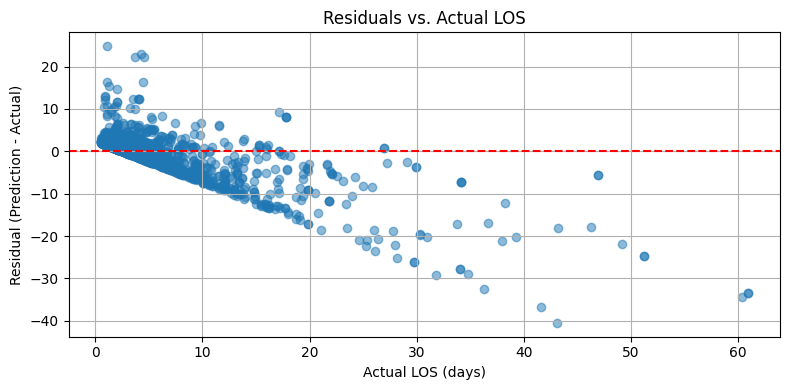

In [ ]:
residuals = y_test_pred - y_test

plt.figure(figsize=(8, 4))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual LOS (days)")
plt.ylabel("Residual (Prediction - Actual)")
plt.title("Residuals vs. Actual LOS")
plt.grid(True)
plt.tight_layout()
plt.show()

Although TabNet is an architecture for tabular data and is theoretically well suited for modeling structured clinical information, our use case shows that the model can only predict the length of stay (LOS) in the ICU to a very limited extent.

Despite preprocessing, integration of medication data (e.g., administered quantities, number of different items), the trained TabNet model achieves a very low explanatory variance (R² ≈ 0.01) on the test set.

The visual analysis show an underestimation of longer lengths of stay, which points to a strong bias toward the mean LOS and a lack of capture of more complex dependencies.

These results suggest that TabNet in this configuration is not suitable for the task, or that it needed more study and tuning.